In [ ]:
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-2.0-cp39-cp39-linux_x86_64.whl
# %pip install transformers
# %pip install tqdm boto3 requests regex sentencepiece sacremoses
# %pip install matplotlib pandas
%pip install torch
%pip install transformers
%pip install tqdm boto3 requests regex sentencepiece sacremoses
%pip install matplotlib pandas

In [23]:
# imports pytorch
import torch

# imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

from abc import ABC
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.nn import functional as F

In [3]:
# train_fullname = '/content/train_data_public.csv'
# test_fullname = '/content/test_public.csv'
train_fullname = 'data/train_data_public.csv'
test_fullname = 'data/test_public.csv'
# device = xm.xla_device()
device = 'cuda'

In [4]:
class AnnoDataSet(Dataset, ABC):
    def __init__(self,texts: list[str], labels: list[str] = None):
        super(Dataset, self).__init__()
        self.texts = texts
        self.labels = labels

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item] if self.labels is not None else None
        return text, label

    def __len__(self):
        return len(self.labels)

In [5]:
def get_dataset() -> (AnnoDataSet, AnnoDataSet, AnnoDataSet):
    train_set, valid_set, test_set = None, None, None

    train_raw = pd.read_csv(train_fullname)
    train_texts: list[str] = [text.strip() for text in train_raw['text'].to_list()]
    train_labels: list[str] = [label_line.strip() for label_line in train_raw['BIO_anno'].to_list()]

    train_set = AnnoDataSet(train_texts, train_labels)

    test_raw = pd.read_csv(test_fullname)
    test_texts: list[str] = [text.strip() for text in test_raw['text'].to_list()]
    test_labels = None

    test_set = AnnoDataSet(test_texts, test_labels)

    return train_set, valid_set, test_set

In [6]:
# 编码labels
class SimpleVocab:
    def __init__(self):
        labels = pd.read_csv(train_fullname)['BIO_anno'].to_list()
        labels = [label_line.split() for label_line in labels]
        all_tokens = [token for label_line in labels for token in label_line] # 这个写法每次看一遍都觉得震撼
        self.token_dict = {}
        self.token_array = []

        # O means none
        self.token_dict['O'] = len(self.token_array)
        self.token_array.append('O')

        for token in all_tokens:
            if token not in self.token_dict:
                self.token_dict[token] = len(self.token_array)
                self.token_array.append(token)

    def __call__(self, tokens):
        assert isinstance(tokens, (list, tuple, str))
        if isinstance(tokens, (list, tuple)):
            return [self(token) for token in tokens]
        else:
            return self.token_dict[tokens]

    def __len__(self):
        return len(self.token_array)

    def to_tokens(self, ids):
        assert isinstance(ids, (list, tuple, int))
        if isinstance(ids, (list, tuple)):
            return [self.to_tokens(idx) for idx in ids]
        else:
            return self.token_array[ids]

    def get_none_token(self):
        return 'O'

    def get_none_id(self):
        return self('O')

In [7]:
def collect(sample:list[tuple[str, str]], tokenizer, label_vocab) -> dict[torch.Tensor]:
    texts, labels = zip(*sample)
    tokens = [list(text) for text in texts]
    tokenized = tokenizer(tokens, padding=True, is_split_into_words=True, return_tensors='pt')

    if labels[0] is None:
        return tokenized


    labels = [label_line.split() for label_line in labels]

    # 对齐label
    none_anno = label_vocab.get_none_token()
    max_len = tokenized['input_ids'][0].shape[-1]
    for idx in range(len(labels)):
        labels[idx] = [none_anno] + labels[idx] + [none_anno]
        # 去除空格导致的标记串过长，理论上超长部分都是'O'，可直接截断
        if len(labels[idx]) > max_len:
            labels[idx] = labels[idx][:max_len]
        # 将标记串填充至max_len
        elif len(labels[idx]) < max_len:
            labels[idx] += [none_anno] * (max_len - len(labels[idx]))
        assert len(labels[idx]) == max_len, f'{len(labels[idx])}, {max_len}'

    tokenized['labels'] = torch.tensor(label_vocab(labels), dtype=torch.int32)
    return tokenized

In [8]:
# model_name = 'bert-base-chinese'
# model_path = 'huggingface/pytorch-transformers'
# bert_tokenizer = torch.hub.load(model_path, 'tokenizer', model_name)

In [9]:
def get_k_fold_dataloader(datas: AnnoDataSet, k: int, k_th: int, batch_size: int,
                          num_workers: int = 0) -> (iter, iter):
    fold_size = len(datas) // k
    X_train, X_valid = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part: tuple[list, list] = datas[idx]
        if j == k_th:
            X_valid = AnnoDataSet(*X_part)
        elif X_train is None:
            X_train = AnnoDataSet(*X_part)
        else:
            X_train = AnnoDataSet(X_train.texts + X_part[0], X_train.labels + X_part[1])

    train_iter = DataLoader(
        X_train,
        batch_size,
        collate_fn=lambda x: collect(x, bert_tokenizer, label_vocab),
        num_workers=num_workers
    )
    valid_iter = DataLoader(
        X_valid,
        batch_size,
        collate_fn=lambda x: collect(x, bert_tokenizer, label_vocab),
        num_workers=num_workers
    )

    return train_iter, valid_iter

In [11]:
from torch import nn
class BertClassification(nn.Module):
    def __init__(self, num_classes,bert, dropout=0):
        super().__init__()
        self.bert = bert
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        hidden_size = 768 # fuck it
        self.Linear1 = nn.Linear(hidden_size, 512)
        self.Relu1 = nn.ReLU()
        self.Linear2 = nn.Linear(512, 256)
        self.Relu2 = nn.ReLU()
        self.Linear3 = nn.Linear(256, num_classes)

    def forward(self, input_ids, token_type_ids, attention_mask):
        out = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )['last_hidden_state']
        out1 = self.dropout1(self.Relu1(self.Linear1(out)))
        out2 = self.dropout2(self.Relu2(self.Linear2(out1)))
        return self.Linear3(out2)

In [12]:
def train_step(base_net, batch, device, loss, optimizer, lr_scheduler):
    output = base_net(
      input_ids=batch['input_ids'].to(device),
      token_type_ids=batch['token_type_ids'].to(device),
      attention_mask=batch['attention_mask'].to(device)
    )
    l = loss(output.permute(0,2,1), batch['labels'].long().to(device))
    l = l.mean()
    l.backward()
    optimizer.step()
    if lr_scheduler is not None:
        lr_scheduler.step()
    optimizer.zero_grad()
    return l.detach().item()

In [13]:
def eval_acc(net, input_iter, device):
  net.to(device)
  all_cnt = 0
  acc_cnt = 0
  with torch.no_grad():
      # with tqdm(total=len(input_iter), desc=f'Eval Acc {k}') as pbar:
          for batch in input_iter:
            output = net(
              input_ids=batch['input_ids'].to(device),
              token_type_ids=batch['token_type_ids'].to(device),
              attention_mask=batch['attention_mask'].to(device)
            )
            output = torch.argmax(output, dim=-1)
            acc_cnt += (output == batch['labels'].to(device)).float().sum().item()
            all_cnt += batch['labels'].shape[0]
            torch.cuda.empty_cache()
            # pbar.update(batch['labels'].shape[0])
  return acc_cnt / all_cnt

In [14]:
def eval_loss(net, input_iter, device):
    net.to(device)
    all_cnt = 0
    loss = 0
    with torch.no_grad():
        # with tqdm(total=len(input_iter), desc=f'Eval Acc {k}') as pbar:
            for batch in input_iter:
                output = net(
                input_ids=batch['input_ids'].to(device),
                token_type_ids=batch['token_type_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
                )
                loss += F.cross_entropy(output.permute(0,2,1), batch['labels'].long().to(device), reduction='sum').detach().item()
                all_cnt += output.shape[0] * output.shape[1]
                # pbar.update(batch['labels'].shape[0])
                torch.cuda.empty_cache()
    return loss / all_cnt

In [15]:
# bert = torch.hub.load(model_path, 'model', model_name)

In [16]:
# bert = BertModel.from_pretrained(bert_path)

In [19]:
from transformers import BertModel, BertTokenizer
from torch.optim import AdamW
from torch.optim.lr_scheduler import LinearLR
import matplotlib.pyplot as plt


bert_path = '/home/user/data/models/bert-base-chinese'
bert_tokenizer = BertTokenizer.from_pretrained(bert_path)

train_dataset, _, test_dataset = get_dataset()
label_vocab = SimpleVocab()

num_epochs = 3
batch_size = 16
fold = 3
lr = 1e-6
fold_training_steps = num_epochs * len(train_dataset) / fold / batch_size * (fold-1)
total_steps = fold_training_steps * fold

def optim_getter(net):
    optimizer = AdamW(net.parameters(), weight_decay=0, lr=lr)
    lr_scheduler = LinearLR(optimizer, start_factor=1, end_factor=0.001, total_iters=fold_training_steps)
    # lr_scheduler = None
    return optimizer, lr_scheduler

def net_getter():
    bert = BertModel.from_pretrained(bert_path)
    net = BertClassification(len(label_vocab), bert)
    net = net.to(device)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

Some weights of the model checkpoint at /home/user/data/models/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Fold 0: 942it [01:41,  9.25it/s]                                                                                                    

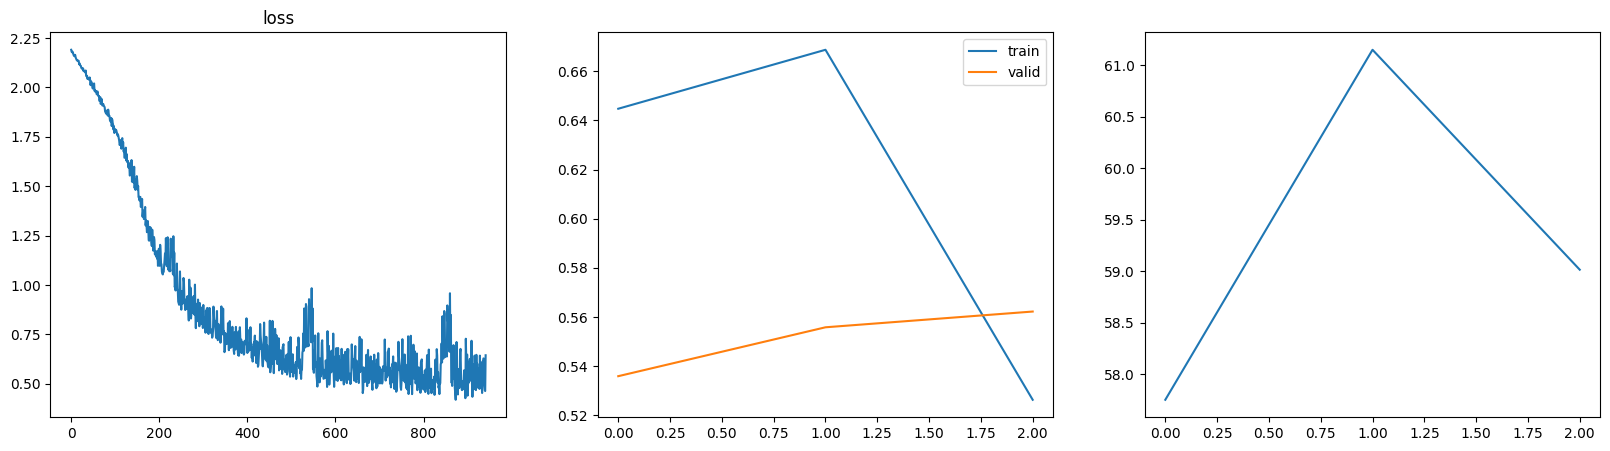

In [21]:
losses = []
train_loss = []
valid_loss = []
valid_acc = []
for k in range(fold):
    train_iter, valid_iter = get_k_fold_dataloader(train_dataset, fold, k, batch_size, 4)
    base_net = net_getter()
    optimizer, lr_scheduler = optim_getter(base_net)

    with tqdm(total=fold_training_steps, desc=f'Fold {k}') as pbar:
        for epoch in range(num_epochs):
            for batch in train_iter:
                loss_qwq = train_step(base_net, batch, device, loss, optimizer, lr_scheduler)
                if k == 0:
                    losses.append(loss_qwq)
                pbar.update(1)
                torch.cuda.empty_cache()
    train_loss.append(loss_qwq)
    valid_loss.append(eval_loss(base_net, valid_iter, device))
    valid_acc.append(eval_acc(base_net, valid_iter, device))


fig, axes = plt.subplots(1,3, figsize=(20,5))
axes[0].plot(range(len(losses)), losses)
axes[0].set_title('loss')
axes[1].plot(range(fold), train_loss, label='train')
axes[1].plot(range(fold), valid_loss, label='valid')
axes[1].legend()
axes[2].plot(range(fold), valid_acc)

In [ ]:
base_net.bert.save_pretrained('/content/base_bert.bin')
torch.save(base_net.Linear1.state_dict(),'/content/base_linear1.ckpt')
torch.save(base_net.Linear2.state_dict(),'/content/base_linear2.ckpt')
torch.save(base_net.Linear3.state_dict(),'/content/base_linear3.ckpt')

In [20]:
torch.cuda.empty_cache()